In [1]:
from fastFM import mcmc
from fastFM import sgd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

In [2]:
df_normal= pd.read_pickle('/Users/serenazhang/Desktop/personalization project/project/Part II/df_normal')
df_popular = pd.read_pickle('/Users/serenazhang/Desktop/personalization project/project/Part II/df_popular')

In [3]:
columns=("msno","song_id","source_screen_name","source_type","source_system_tab","city",
         "genre_ids","artist_name","registered_via","language")
x_train,x_test,y_train,y_test=train_test_split(df_normal.loc[:,columns],
                                               df_normal.loc[:,"ztarget"],test_size=0.2)
px_train,px_test,py_train,py_test=train_test_split(df_popular.loc[:,columns],
                                               df_popular.loc[:,"ztarget"],test_size=0.2)


In [4]:
def train_test(data,xtr,xtes,ytr,ytest,featurelist):
    temp=data.copy()
    for i in columns:
        if i=="song_length":
            continue
        if i =="artist_name":
            k="Various Artists"
            temp.loc[temp[i]=="unknown",i]=k
        elif any(temp[i] == "unknown")==True:
            k= temp[i].value_counts().idxmax()
            temp.loc[temp[i]=="unknown",i]=k
    #vectorize to sparse matrix
    vectorizer = DictVectorizer()
    temp=temp.loc[:,featurelist].to_dict(orient="record")
    vectorizer.fit(temp)
    temp1=xtr.to_dict(orient="record")
    temp2=xtes.to_dict(orient="record")
    xtrain= vectorizer.transform(temp1)
    xtest=vectorizer.transform(temp2)
    result=[xtrain,xtest,ytr,ytest]
    return result

# Baseline

In [10]:
normal_list=train_test(df_normal,x_train,x_test,y_train,y_test,("msno","song_id"))
xtrain=normal_list[0]
xtest=normal_list[1]
ytrain=normal_list[2]
base_mcmc=mcmc.FMClassification(n_iter=100, rank=8, init_stdev=0.1)
pred=base_mcmc.fit_predict_proba(xtrain, ytrain, xtest)
print("accuracy","precision","recall","auc")
print(evaluate(pred,y_test,0.5))

accuracy precision recall auc
[0.666, 0.674, 0.652, 0.7297111845084528]


# Finding the Best Features

In [6]:
prev=baseline
base_features=["msno","song_id"]
features=("source_screen_name","source_type","source_system_tab","city",
         "genre_ids","artist_name","registered_via","language")

for i in features:
    base_features.append(i)
    print("===== Starting Feature:",i,"======")
    normal_list=train_test(df_normal,x_train,x_test,y_train,y_test,tuple(base_features))
    xtrain=normal_list[0]
    xtest=normal_list[1]
    ytrain=normal_list[2]
    ytest=normal_list[3]
    
    mcmcmodel=mcmc.FMClassification(n_iter=100, rank=8, init_stdev=0.1)
    pred=mcmcmodel.fit_predict_proba(xtrain, ytrain, xtest)
    current_roc=roc_auc_score(ytest, pred)
    print("current roc:",current_roc)
    
    if current_roc<=prev:
        deleted=base_features.pop()
        print(deleted,"is not going to be included")
    else:
        prev=current_roc
print(base_features)

===== Starting Feature: source_screen_name ======
current roc: 0.790733232324
===== Starting Feature: source_type ======
current roc: 0.798606564065
===== Starting Feature: source_system_tab ======
current roc: 0.799562716334
===== Starting Feature: city ======
current roc: 0.798909810122
city is not going to be included
===== Starting Feature: genre_ids ======
current roc: 0.801783134985
===== Starting Feature: artist_name ======
current roc: 0.804875897525
===== Starting Feature: registered_via ======
current roc: 0.803133127304
registered_via is not going to be included
===== Starting Feature: language ======
current roc: 0.809248413698
['msno', 'song_id', 'source_screen_name', 'source_type', 'source_system_tab', 'genre_ids', 'artist_name', 'language']


# Tuning Parameters

- solver: sgd or mcmc
- rank: [2,3,4,5,6,7,8]

In [7]:
def cal_accuracy(rating,pred):
    correct_count = 0
    true_positive = 0
    positive_pred = 0
    positive_rating = 0
    for i in range(len(rating)):
        if pred[i] == rating[i]:
            correct_count += 1.0
        if rating[i] == 1 and pred[i] == 1:
            true_positive +=  1.0
        if pred[i] == 1:
            positive_pred += 1.0
        if rating[i] == 1:
            positive_rating += 1.0
    
    accuracy = float("{0:.3f}".format(correct_count / len(rating)))
    #to avoid division by zero error
    if positive_pred==0:
        precision=0
    else:
        precision = float("{0:.3f}".format(true_positive / positive_pred))
    recall = float("{0:.3f}".format(true_positive / positive_rating))
    return [accuracy,precision,recall]

In [8]:
def evaluate(pred,ytest,threshold):
    binary_pred = [1 if i> threshold else -1 for i in pred]
    ytest=ytest.tolist()
    result=[i for i in cal_accuracy(ytest,binary_pred)]

    result.append(float(roc_auc_score(ytest, pred)))
    return result

In [9]:
def evaluate_param(solver,rank,threshold):
    if type(rank) is list:
        param=rank
        eval=np.zeros(shape=(len(rank),4))
        for i in range(0,len(rank)):
            if solver=="sgd":
                model=sgd.FMClassification(n_iter=100, rank=rank[i])
                model.fit(xtrain,ytrain)
                pred=model.predict_proba(xtest)
                eval[i]= evaluate(pred,ytest,threshold)
            else:
                model=mcmc.FMClassification(n_iter=100, rank=rank[i])
                pred=model.fit_predict_proba(xtrain, ytrain, xtest)
                eval[i]= evaluate(pred,ytest,threshold)
    elif type(solver) is list:
        param=solver
        eval=np.zeros(shape=(len(solver),4))
        for i in solver:
            if i=="sgd":
                model=sgd.FMClassification(n_iter=100, rank=8)
                model.fit(xtrain,ytrain)
                pred=model.predict_proba(xtest)
                eval[0]= evaluate(pred,ytest,threshold)
            else:
                model=mcmc.FMClassification(n_iter=100, rank=8)
                pred=model.fit_predict_proba(xtrain, ytrain, xtest)
                eval[1]= evaluate(pred,ytest,threshold)
        

    df_param=pd.DataFrame({"param":param,"accuracy": eval[:,0],"precision":eval[:,1],
                           "recall":eval[:,2],"auc":eval[:,3]})
    df_param=df_param[["param","accuracy","precision","recall","auc"]]
    return df_param

In [10]:
solver_df=evaluate_param(["sgd","mcmc"],8,0.5)

In [11]:
solver_df

,param,accuracy,precision,recall,auc
0,sgd,0.582,0.557,0.847,0.648656
1,mcmc,0.728,0.738,0.716,0.809248


In [12]:
rank_df=evaluate_param("mcmc",[6,7,8,9,10],0.5)

In [13]:
rank_df

,param,accuracy,precision,recall,auc
0,6,0.722,0.732,0.712,0.804020
1,7,0.725,0.737,0.712,0.806057
2,8,0.728,0.738,0.716,0.809248
3,9,0.727,0.738,0.714,0.808353
4,10,0.730,0.740,0.720,0.811439


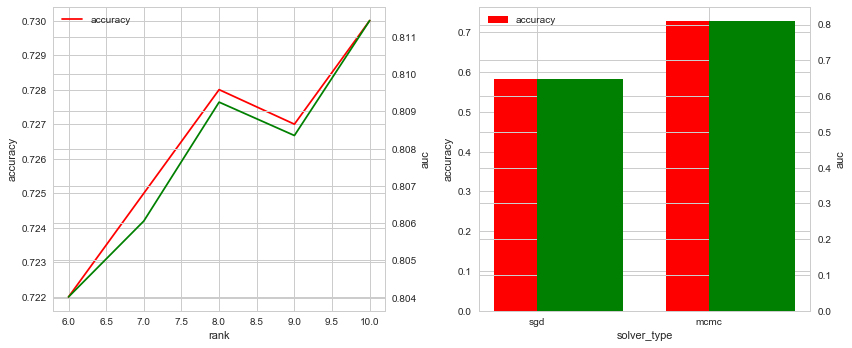

In [14]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
# plotting metrics as rank changes
axes[0].plot(rank_df["param"], rank_df["accuracy"], color="red",label="accuracy")
ax2 = axes[0].twinx()
ax2.plot(rank_df["param"], rank_df["auc"],color="green",label="auc")
ax2.set_ylabel('auc')
axes[0].set( xlabel = "rank", ylabel = "accuracy")

# plotting metrics given different similarity types
x_axis=np.arange(len(solver_df["param"]))
axes[1].bar(x_axis, solver_df["accuracy"], width=0.5,color="red",align="center",label="accuracy")
ax3 = axes[1].twinx()
ax3.bar(x_axis, solver_df["auc"],width=0.5,color="green",align="edge",label="auc")
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(solver_df["param"])
ax3.set_ylabel('auc')
axes[1].set( xlabel = "solver_type", ylabel = "accuracy")
axes[0].legend()
axes[1].legend()
plt.tight_layout()

# Model Performance on Popular Users&Items

In [15]:
popular_list=train_test(df_popular,px_train,px_test,py_train,py_test,tuple(['msno', 'song_id', 
                                                                           'source_screen_name', 'source_type', 
                                                                           'source_system_tab', 'city', 
                                                                           'genre_ids', 'artist_name', 'language']))
xtrain=popular_list[0]
xtest=popular_list[1]
ytrain=popular_list[2]
ytest=popular_list[3]

In [16]:
mcmcmodel=mcmc.FMClassification(n_iter=100, rank=9, init_stdev=0.1)
pred=mcmcmodel.fit_predict_proba(xtrain, ytrain, xtest)


In [17]:
print("accuracy","precision","recall","auc")
print(evaluate(pred,ytest,0.5))
print(0.728,0.735,0.722,0.808859)

accuracy precision recall auc
[0.718, 0.734, 0.738, 0.7966639627648082]
0.728 0.735 0.722 0.808859


# Fitting a Logistic Regression in the end

In [55]:
xtrain=normal_list[0]
xtest=normal_list[1]
ytrain=normal_list[2]
ytest=normal_list[3]

In [56]:
from sklearn.linear_model import LogisticRegression
model=mcmc.FMRegression(n_iter=100, rank=9)
predtrain=model.fit_predict(xtrain, ytrain, xtrain)
pred=model.fit_predict(xtrain, ytrain, xtest)


In [57]:
ytrain=ytrain.tolist()

In [58]:
LogReg = LogisticRegression()
LogReg.fit(predtrain.reshape(-1,1), ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
log_pred = LogReg.predict(pred.reshape(-1,1))

In [60]:
print("accuracy","precision","recall","auc")
print(evaluate(log_pred,y_test,0.5))
print(0.728,0.735,0.722,0.808859)

accuracy precision recall auc
[0.736, 0.743, 0.734, 0.7364705556528766]
0.728 0.735 0.722 0.808859
